In [147]:
import sys, os, json, pickle, gzip, copy, torch, numbers, tqdm, gpytorch
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from src.utils import ActiveElements, MetalElements, Element, AllElements
from src.utils import composit_parser
from src.feature import composition_to_feature

from pymatgen.core import Composition, Element

from scipy.stats import gaussian_kde
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR

# test - toy

## 1D

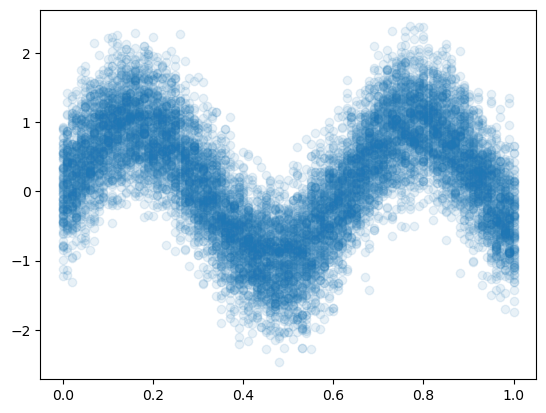

In [90]:
x1, x2 = np.meshgrid(np.linspace(0,1,101), np.linspace(0,1,101))
toy_x = x1.reshape(-1,1)
toy_y = np.sin(toy_x.reshape(-1) * 10) + np.random.normal(0, 0.5, size=toy_x.shape[0])
plt.scatter(toy_x.reshape(-1), toy_y, alpha=0.1)

In [92]:
kernel = RBF(length_scale=1, length_scale_bounds=(1e-4, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
mask = np.zeros_like(toy_y).astype(bool)
mask[:1000] = True
np.random.seed(100)
np.random.shuffle(mask)
gpr.fit(toy_x[mask], toy_y[mask])

GaussianProcessRegressor(kernel=RBF(length_scale=1), n_restarts_optimizer=10)

In [112]:
x = np.linspace(0,1,500)
p_avg, p_std = gpr.predict(x.reshape(-1,1), True)

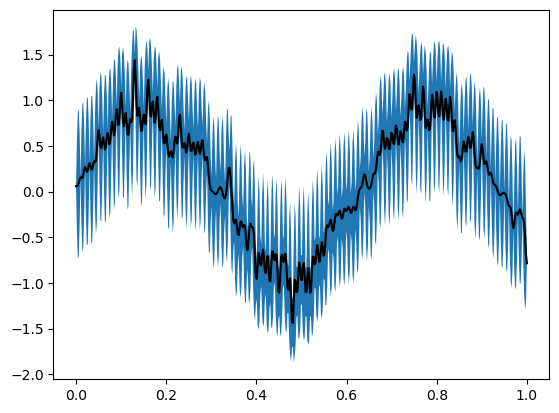

In [113]:
plt.fill_between(x, p_avg - p_std, p_avg+p_std)
plt.plot(x, p_avg, 'k')

## 2D

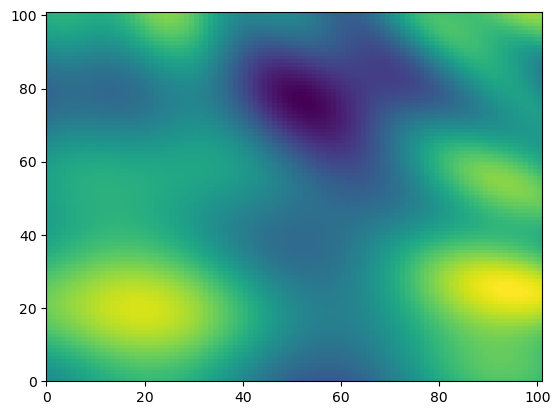

In [148]:
x1, x2 = np.meshgrid(np.linspace(0,1,101), np.linspace(0,1,101))
toy_x = np.hstack([x1.reshape(-1, 1), x2.reshape(-1, 1)])
toy_y = (np.cos(x1.reshape(-1) * np.pi * 2) + 
        np.sin(x1.reshape(-1) * np.pi * 3 - 7) * 2 + 
        np.cos(x2.reshape(-1) * np.pi * 5 - 3) + 
        np.sin(x2.reshape(-1) * np.pi * 2) * 2 + 
        np.cos(x2.reshape(-1) * x1.reshape(-1) * np.pi * 8) 
)
plt.pcolormesh(toy_y.reshape(101,101))

In [150]:
kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.01, n_restarts_optimizer=10)
mask = np.zeros_like(toy_y).astype(bool)
mask[:100] = True
np.random.seed(100)
np.random.shuffle(mask)
xs = []
ys = []
for i in range(20):
    xs.append(toy_x[mask])
    ys.append(toy_y[mask] + np.random.normal(0, 0.5, mask.sum()))
gpr.fit(np.vstack(xs), np.hstack(ys))
print(gpr.kernel_)

KeyboardInterrupt: 

In [183]:
N = 50
x = np.hstack([x.reshape(-1,1) for x in np.meshgrid(np.linspace(0,1,N), np.linspace(0,1,N))])
p_avg, p_std = gpr.predict(x, True)
f, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0,0].pcolormesh(toy_y.reshape(101,101))
axs[0,1].pcolormesh(mask.reshape(101,101))
axs[1,0].pcolormesh(p_avg.reshape(N,N))
axs[1,1].pcolormesh(p_std.reshape(N,N))

AttributeError: 'GaussianProcessRegressor' object has no attribute 'alpha_'

- gp

In [181]:
class SingleGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

X = torch.from_numpy(toy_x).float().cuda()
Y = torch.from_numpy(toy_y).float().cuda()

mask = np.zeros(toy_y.shape[0]).astype(bool)
mask[:2000] = True
np.random.shuffle(mask)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SingleGPModel(X[mask], Y[mask], likelihood).cuda()

opt = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
cnt = 0
best_loss = 1e5
for i in range(2000):
    model.train()
    likelihood.train()
    opt.zero_grad()
    out = model(X[mask])
    loss = -mll(out, Y[mask])
    loss.backward()
    opt.step()
    train_loss = loss.detach().cpu().item()

    model.eval()
    likelihood.eval()
    with torch.no_grad():

        pred = model(X[~mask])
        test_loss = -mll(pred, Y[~mask]).cpu().item()

        err = pred.mean.cpu() - Y[~mask].cpu()
    if test_loss > best_loss:
        cnt += 1
    else:
        best_loss = test_loss
        best_model = model.state_dict()
        cnt = 0
    if cnt > 20:
        model.load_state_dict(best_model)
        break
    print('{:3d} {:12.5f} {:12.5f} {:12.5f}'.format(
        i, train_loss, test_loss, np.abs(err).mean()))

  0      2.63092      1.81760      1.11605
  1      2.40358      1.70012      1.06469
  2      2.20667      1.59873      1.01586
  3      2.03950      1.51243      0.96780
  4      1.89916      1.44207      0.91964
  5      1.78136      1.38626      0.87100
  6      1.68251      1.34091      0.82284
  7      1.59968      1.30128      0.77581
  8      1.53141      1.26611      0.72851
  9      1.47504      1.23664      0.68046
 10      1.42649      1.21255      0.63349
 11      1.38281      1.19356      0.58777
 12      1.34420      1.17577      0.54518
 13      1.30994      1.15832      0.50587
 14      1.27909      1.14098      0.46975
 15      1.25189      1.12228      0.43588
 16      1.22664      1.10314      0.40446
 17      1.20196      1.08021      0.37150


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 256.4930725097656 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 18      1.18164      0.80804      0.33824


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 47.17886734008789 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 19      1.16149      1.13801      0.30302


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 24910.373046875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 20      1.13812      1.85139      0.26959
 21      1.11728      0.99033      0.24008
 22      1.09576      0.95296      0.20935


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 395.1663513183594 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 23      1.06709      1.22868      0.18068
 24      1.04308      0.91379      0.15703
 25      1.01917      0.88662      0.13585


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 94.35133361816406 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 26      0.99418      0.86420      0.11908
 27      0.97169      0.83225      0.10351
 28      0.94504      0.80039      0.08808


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 914.4274291992188 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 29      0.92046      0.76699      0.07773
 30      0.88832      0.74453      0.06909
 31      0.85918      0.70971      0.06017
 32      0.83018      0.67355      0.05493
 33      0.80063      0.63781      0.05132


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 55762.7109375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 34      0.76786      0.40167      0.04599


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 97.00939178466797 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 35      0.74762      0.56375      0.04304
 36      0.70491      0.51757      0.03866


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 441786.5 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 37      0.67082    410.87170      0.03755


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 33122.70703125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 38      0.62521      0.25704      0.03574


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 4769.61474609375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 39      0.59080     15.47979      0.03497


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 1372516.125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 40      0.55176    294.68768      0.03446


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 2753062.75 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 41      0.50766   6462.16650      0.03314


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 16396988.0 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 42      0.46780    117.47233      0.03257


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 491161.5 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 43      0.42174   1407.29956      0.03013


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 394.3592834472656 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 44      0.37285     -1.21181      0.03003


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 187020.4375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 45      0.33657     -0.84245      0.03076


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 1351.3743896484375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 46      0.27876     -1.47015      0.02797


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 71929.6875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 47      0.23321     -2.75680      0.02932


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 21596554.0 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 48      0.17826 128163.38281      0.02967


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 1181.97509765625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 49      0.13314     -0.64910      0.02710


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 37317.375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 50      0.07701     -1.10022      0.02628


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 141918.171875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 51      0.02060     -3.72305      0.02702


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 10352.6669921875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 52     -0.02068     -3.69000      0.02791


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 3203104.0 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 53     -0.08298     -4.58785      0.03061


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 10150357.0 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 54     -0.12881     -3.69767      0.02992


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 28046860.0 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 55     -0.17762     -3.79466      0.02905


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 32373.998046875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 56     -0.23223     -4.20035      0.02992


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 157754.09375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 57     -0.28086     -4.47921      0.03030


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 224602.046875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 58     -0.33474     -5.11727      0.02945


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 1602757.875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 59     -0.38887     -5.02852      0.03092


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 195256.984375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 60     -0.43716     -6.20824      0.02957


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 4671254.5 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 61     -0.48528     -5.17162      0.03252


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 775889.5 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 62     -0.53625     -6.58338      0.03041


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 122965.4140625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 63     -0.59719     -5.53249      0.02997


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 4358848.5 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 64     -0.63308     -3.35151      0.02962


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 2224224.0 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 65     -0.69900     -7.54329      0.03044


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 1542303.875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 66     -0.74014     -5.19765      0.02723


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 6044590.5 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 67     -0.77114     -5.45998      0.02764


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 1247332.75 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 68     -0.83082     -4.61613      0.02863


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 1527408.375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 69     -0.85989     -6.11979      0.02777


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 681018.25 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 70     -0.92650     -5.01778      0.02765


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 4011071.5 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 71     -0.97644     -5.51623      0.02844


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 9681116.0 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 72     -1.01730     -4.10718      0.02963


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 1401836.875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 73     -1.06964     -4.32730      0.03006


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 27434514.0 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 74     -1.07301 208519.34375      0.02983


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 168728224.0 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 75     -1.12913     -6.07245      0.02979


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 374755.53125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 76     -1.17186     -5.33418      0.03060


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 7411212.0 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 77     -1.19118     -4.81547      0.03015


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 21790692.0 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 78     -1.20954     -3.25663      0.03095


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 1205976.5 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 79     -1.24829   3316.76294      0.02981


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 688803.25 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 80     -1.26948     -5.08080      0.02979


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

CG terminated in 1000 iterations with average residual norm 409552.375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.



 81     -1.30399     -4.48563      0.02897


KeyboardInterrupt: 

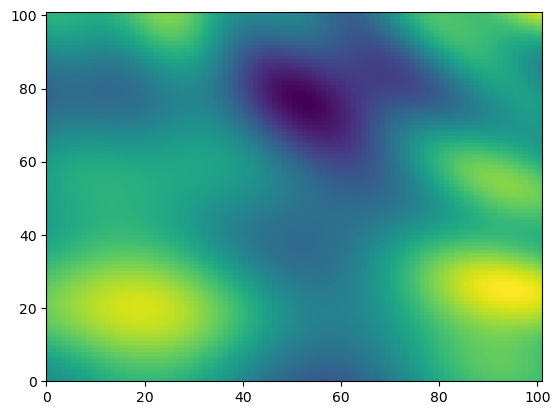

In [182]:
model.load_state_dict(best_model)

with torch.no_grad():
    out = model(X.cuda())
plt.pcolormesh(out.mean.reshape(101,101).cpu().numpy())


# test - synthesis

## dataset

In [2]:
from src.data import ReactionGraphDataset, ReactionDataset
from src.networks import GraphCVAE, CVAE, GraphConvolutionBlock, GraphAttentionBlock
from src.trainer import VAETrainer, BaseTrainer

GDSM = ReactionGraphDataset(feat_type='cgcnn')
GDSM.from_file('../data/screened_single_source_conditional_reaction.pkl.gz', 
               heat_temp_key=('heat_temp','median'),
               heat_time_key=('heat_time','median'))

In [211]:
years = np.array([d.year for d in GDSM])
train_mask = years > 2017
test_idx = np.where(train_mask)[0]
train_idx = np.where(~train_mask)[0]
inducing_idx = np.random.permutation(train_idx)[:3000]

feat, _ = GDSM.cfn(GDSM)
target_feat = feat['target_feat']
temp_label, time_label = feat['condition_feat'].T
train_dl = DataLoader(GDSM, batch_size=1024, sampler=SubsetRandomSampler(train_idx), collate_fn=GDSM.cfn)
test_dl = DataLoader(GDSM, batch_size=1024, sampler=test_idx, collate_fn=GDSM.cfn)

In [226]:
class SingleGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.shape[0])
        variational_strategy = gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

model = SingleGPModel(target_feat[train_mask]).to('cuda')
likelihood = gpytorch.likelihoods.GaussianLikelihood().to('cuda')
target_mean = temp_label[train_mask].mean()
target_std = temp_label[train_mask].std()

vopt = gpytorch.optim.NGD(model.variational_parameters(), num_data=len(train_idx),
                          lr=0.01)
popt = torch.optim.Adam([{'params':model.parameters(), 'params':likelihood.parameters()}], 
                        lr=0.01)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(train_idx))

for i in range(2000):
    train_loss = 0
    model.train()
    likelihood.train()

    for batch, info in train_dl:
        X = batch['target_feat'].to('cuda')
        Y = (batch['condition_feat'][:, 0].to('cuda') - target_mean) / target_std
        vopt.zero_grad()
        popt.zero_grad()

        out = model(X)
        loss = -mll(out, Y)
        print(loss)
        loss.backward()
        vopt.step()
#        popt.step()
        train_loss += loss.detach().cpu().item()

    model.eval()
    likelihood.eval()
    errs = []
    test_loss = 0
    with torch.no_grad():
        for batch, info in test_dl:
            X = batch['target_feat'].to('cuda')
            Y = (batch['condition_feat'][:, 0].to('cuda') - target_mean) / target_std

            pred = model(X)
            test_loss += -mll(pred, Y).cpu().item()

            err = pred.mean.cpu() - Y.cpu()
            errs.append(err.numpy())
    
    print('{:3d} {:12.5f} {:12.5f} {:12.5f}'.format(
        i, train_loss / len(train_dl), test_loss / len(test_dl), np.abs(np.hstack(errs)).mean()))

tensor(1.8765, device='cuda:0', grad_fn=<NegBackward0>)
tensor(1211.7301, device='cuda:0', grad_fn=<NegBackward0>)
tensor(10335001., device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.8061e+10, device='cuda:0', grad_fn=<NegBackward0>)


KeyboardInterrupt: 

In [193]:
out = model(target_feat.cuda())
llh = likelihood(target_feat.cuda())

In [203]:
out.mean.cpu().detach() * target_std + target_mean, temp_label

(tensor([0.2859, 0.2859, 0.2859,  ..., 0.2861, 0.2865, 0.2863]),
 tensor([ 0.4732,  0.2482,  0.1107,  ...,  0.3731, -0.3119,  0.7232]))

In [138]:
#out = model(torch.vstack([d.target_feat for d in GDSM]).cuda())
g = gaussian_kde(out.mean.detach().cpu().numpy())
#x = np.linspace(-1,1,100)
#plt.plot(x, g(x))

0.002115923

In [4]:
model_outputs = {}

In [14]:
from src.networks import FCNNBlock

crit = torch.nn.GaussianNLLLoss()
model = FCNNBlock(input_dim=91, output_dim=2, batch_norm=False, dropout=0.5)
model.to('cuda')
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
measures = []
best_loss = 1e5
for i in range(200):
    train_loss = 0
    model.train()

    for batch, info in train_dl:
        X = batch['target_feat'].to('cuda')
        Y = batch['condition_feat'].to('cuda')[:, 1:]
        opt.zero_grad()
        out = model(X)
        mean, var = torch.chunk(out, 2, -1)
        var = torch.abs(var)
        loss = crit(mean, Y, var)
        loss.backward()
        opt.step()
        train_loss += loss.detach().cpu().item()

    model.eval()
    errs = []
    test_loss = 0
    with torch.no_grad():
        for batch, info in test_dl:
            X = batch['target_feat'].to('cuda')
            Y = batch['condition_feat'].to('cuda')[:, 1:]

            out = model(X)
            mean, var = torch.chunk(out, 2, -1)
            var = torch.abs(var)
            test_loss += crit(mean, Y, var).cpu().item()
            err = mean.cpu() - Y.cpu()
            errs.append(err.numpy())
    
    measure = [train_loss / len(train_dl), test_loss / len(test_dl), np.abs(np.vstack(errs)).mean()]
    print('{:3d} {:12.5f} {:12.5f} {:12.5f}'.format(i, *measure))
    measures.append(measure)
    if test_loss < best_loss:
        best_loss = test_loss
        best_model = model.state_dict()


  0      7.11621      0.30482      0.38185
  1      2.98774     -0.10902      0.37932
  2      1.89940     -0.12591      0.37613
  3      2.05274     -0.17010      0.37735
  4      1.32810     -0.10179      0.37946
  5      1.76062      2.64723      0.37901
  6      3.26257      3.45413      0.38247
  7      1.90164      1.62757      0.38156
  8      1.44354      0.96708      0.37790
  9      2.59315     -0.22902      0.38348
 10      0.36187     -0.22931      0.38524
 11      0.15544     -0.22994      0.38542
 12      0.14313     -0.22939      0.38518
 13      0.16215     -0.22761      0.38523
 14      0.10805     -0.22586      0.38563
 15      0.17701     -0.22670      0.38525
 16      2.79231     -0.21248      0.38796
 17     -0.04910     -0.20139      0.38740
 18      0.09632     -0.19160      0.38743
 19     -0.05829     -0.19381      0.38699
 20     -0.07328     -0.19287      0.38681
 21     -0.06269     -0.19535      0.38693
 22     -0.02984     -0.19221      0.38648
 23     -0.

In [11]:
model.load_state_dict(best_model)
model.eval()
with torch.no_grad():
    pred = model(GDSM.cfn(GDSM)[0]['target_feat'].to('cuda'))
mean, var = torch.chunk(pred, 2, -1)
model_outputs['both_temp'] = mean.cpu().numpy()[:, 0], np.abs(var.cpu().numpy())[:, 0]
model_outputs['both_time'] = mean.cpu().numpy()[:, 1], np.abs(var.cpu().numpy())[:, 1]

In [15]:
model.load_state_dict(best_model)
model.eval()
with torch.no_grad():
    pred = model(GDSM.cfn(GDSM)[0]['target_feat'].to('cuda'))
mean, var = torch.chunk(pred, 2, -1)
model_outputs['sing_time'] = mean.cpu().numpy().reshape(-1), np.abs(var.cpu().numpy().reshape(-1))

In [115]:
with open('../dump/gaussian.ouput.pkl','rb') as f:
    model_outputs = pickle.load(f)

In [17]:
inp_vecs = torch.vstack([d.target_feat for d in GDSM])
dist = torch.cdist(inp_vecs, inp_vecs)

In [119]:
mask = dist.numpy() < 1e-2
idxs = []
for i in np.where(mask.sum(1) > 50)[0]:
    j = np.argmin(dist[i]).item()
    if j not in idxs:
        idxs.append(j)
#    if (mask[j] != mask[i]).sum() != 0:
#        idxs.append(i)
len(idxs)

298

In [97]:
values = {}
for i in torch.where(dist[0] < 3e-2)[0]:
    tstr = composit_parser(GDSM[i].target_comp)
    if tstr not in values.keys():
        values[tstr] = {'pred':{k:(v[0][i], v[1][i]) for k,v in model_outputs.items()}, 'vals':[]}
    values[tstr]['vals'].append(GDSM[i].condition_feat.numpy())


In [79]:
t1, t2 = np.vstack([d.condition_feat.numpy() for d in GDSM]).T

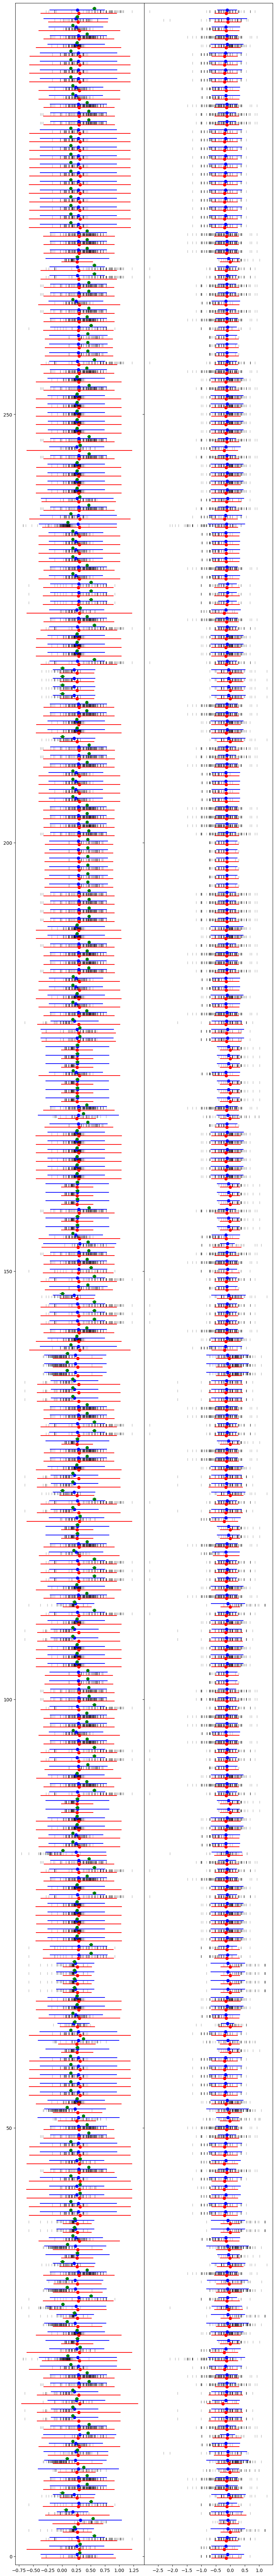

In [156]:
f, axs = plt.subplots(1,2,figsize=(10,100), sharey=True)
for i,idx in enumerate(idxs):
    axs[0].errorbar(model_outputs['both_temp'][0][idx], [i-0.2], xerr=model_outputs['both_temp'][1][idx], color='r', marker='o')
    axs[0].errorbar(model_outputs['sing_temp'][0][idx], [i+0.2], xerr=model_outputs['sing_temp'][1][idx], color='b', marker='o')
    axs[0].errorbar(skgpr_out_mean[idx], [i+0.4], xerr=skgpr_out_std[idx], color='g', marker='o')
    axs[0].scatter(t1[mask[idx]], [i]*mask[idx].sum(), color='k', marker='|', alpha=0.2)
    axs[1].errorbar(model_outputs['both_time'][0][idx], [i-0.2], xerr=model_outputs['both_time'][1][idx], color='r', marker='o')
    axs[1].errorbar(model_outputs['sing_time'][0][idx], [i+0.2], xerr=model_outputs['sing_time'][1][idx], color='b', marker='o')
    axs[1].scatter(t2[mask[idx]], [i]*mask[idx].sum(), color='k', marker='|', alpha=0.2)
axs[0].set_ylim(-1, len(idxs))
f.subplots_adjust(wspace=0)

In [ ]:
target_feat = np.vstack([d.target_feat.numpy() for d in GDSM])
condition_feat = np.vstack([d.condition_feat.numpy() for d in GDSM])

In [145]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = RBF(length_scale=1, length_scale_bounds=(1e-4, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1.0, n_restarts_optimizer=10)
gpr.fit(target_feat, condition_feat[:, 0])

GaussianProcessRegressor(alpha=1.0, kernel=RBF(length_scale=1),
                         n_restarts_optimizer=10)

In [148]:
skgpr_out_mean, skgpr_out_std = gpr.predict(target_feat, return_std=True)

In [149]:
with open('../dump/sklearn_gpr.model_and_output.pkl','wb') as f:
    pickle.dump([gpr, skgpr_out_mean, skgpr_out_std], f)

In [118]:
with open('../dump/sklearn_gpr.model_and_output.pkl','rb') as f:
    gpr, skgpr_out_mean, skgpr_out_std = pickle.load(f)

In [126]:
DS = ReactionGraphDataset(feat_type='cgcnn')
DS.from_file('../data/screened_unique_reaction_ss.pkl.gz','rb',
             heat_temp_fnc=lambda x: x['heat_temp_med'],
             heat_time_fnc=lambda x: x['heat_time_med'],
             )

In [130]:
feat, info = DS.cfn(DS)
x = feat['target_feat'].numpy()
y = feat['condition_feat'].numpy()

In [145]:
pred3 = gpr.predict(x)

In [146]:
from sklearn.metrics import r2_score


r2_score(y.T[0], pred3)

0.48673665611574213

In [ ]:
class RBFKernel(torch.nn.Module):
    def __init__(self, input_dim):
        super(RBFKernel, self).__init__()
        self.input_dim = input_dim
        self.variance = torch.nn.Parameter(torch.tensor([1.0]), requires_grad=True)
        self.lengthscale = torch.nn.Parameter(torch.randn(input_dim).abs(), requires_grad=True)

    def forward(self, x1, x2=None):
        # Compute the squared Euclidean distance between x1 and x2
        x1 = x1 / self.lengthscale
        x1s = torch.pow(x1, 2).sum(1)

        if x2 is None: 
            dist = -2 * x1.mm(x1.T) + x1s.view(-1,1) + x1s.view(1,-1)
        else:
            x2 = x2 / self.lengthscale
            x2s = torch.pow(x2, 2).sum(1)
            dist = -2 * x1.mm(x2.T) + x1s.view(-1,1) + x2s.view(1,-1)

        # Compute the kernel matrix
        kernel_matrix = self.variance * torch.exp(-0.5 * dist)

        return kernel_matrix


In [59]:
torch.abs(torch.randn(10))

tensor([1.2797, 0.5692, 0.6242, 1.7780, 0.7217, 0.8491, 0.5731, 0.8418, 0.6193,
        0.3363])

In [76]:
x = torch.rand(256, 91)

In [74]:
def f1(x):
    return torch.pow(torch.cdist(x, x), 2)

def f2(x):
    xs = torch.pow(x, 2).sum(1)
    return -2 * x.mm(x.T) + xs.view(1,-1) + xs.view(-1,1)

%timeit f1(x)
%timeit f2(x)

39.3 µs ± 92 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
23.1 µs ± 31.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# check distribution of conditions - temp & time

In [4]:
from src.data import ReactionGraphDataset

DS = ReactionGraphDataset(feat_type='cgcnn')
DS.from_file('../data/screened_unique_reaction_ss.pkl.gz', 
             heat_temp_fnc=lambda x: x['heat_temp_med'],
             heat_time_fnc=lambda x: x['heat_time_med'])
feat, info = DS.cfn(DS)

In [10]:
from sklearn.manifold import TSNE

tvec = TSNE().fit_transform(feat['target_feat'].numpy())
tx, ty = tvec.T
y1, y2 = feat['condition_feat'].numpy().T

tx.min(), tx.max(), ty.min(), ty.max()

(-118.23475, 124.91958, -118.739716, 109.61939)

Text(0.5, 1.0, 'Time')

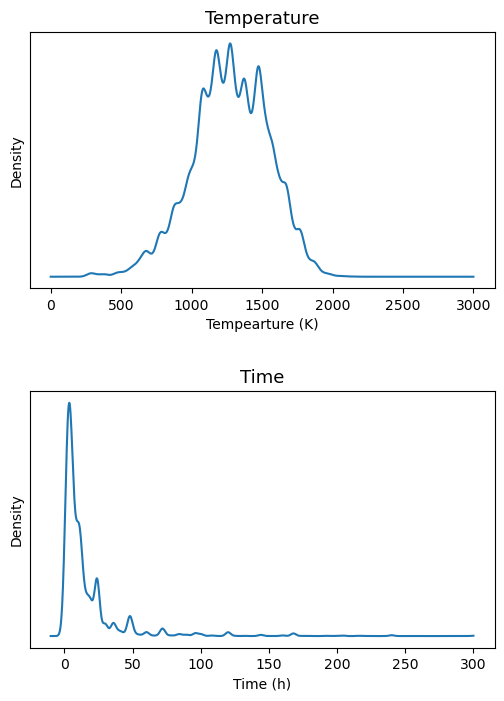

In [103]:
from src.utils import heat_time_denorm, heat_tempearture_denorm
f, axs = plt.subplots(2,1,figsize=(6,8))
g = gaussian_kde(heat_tempearture_denorm(y1), bw_method=0.1)
x = np.linspace(0,3000,1000)
axs[0].plot(x, g(x))
g = gaussian_kde(heat_time_denorm(y2), bw_method=0.05)
x = np.linspace(-10,300,1000)
axs[1].plot(x, g(x))

axs[0].set_xlabel(r'Tempearture (K)' )
axs[1].set_xlabel(r'Time (h)' )
f.subplots_adjust(hspace=0.4)
for ax in axs:
    ax.set_yticks([])
    ax.set_ylabel('Density')
axs[0].set_title('Temperature', fontsize=13)
axs[1].set_title('Time', fontsize=13)

Text(0.5, 1.0, 'Time')

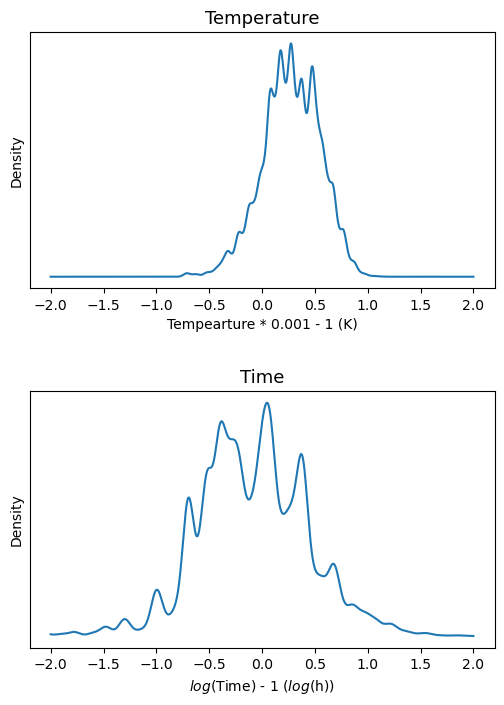

In [100]:
f, axs = plt.subplots(2,1,figsize=(6,8))
g = gaussian_kde(y1, bw_method=0.1)
x = np.linspace(-2,2,1000)
axs[0].plot(x, g(x))
g = gaussian_kde(y2, bw_method=0.1)
axs[1].plot(x, g(x))
axs[0].set_xlabel(r'Tempearture * 0.001 - 1 (K)' )
axs[1].set_xlabel(r'$log$(Time) - 1 ($log$(h))' )
f.subplots_adjust(hspace=0.4)
for ax in axs:
    ax.set_yticks([])
    ax.set_ylabel('Density')
axs[0].set_title('Temperature', fontsize=13)
axs[1].set_title('Time', fontsize=13)

In [112]:
n = 12
g1x, g1y, g1z = [v.reshape(-1) for v in np.meshgrid(np.linspace(-120,130,n), np.linspace(-120,110,n), np.linspace(-1,1.5,n))]
g2x, g2y, g2z = [v.reshape(-1) for v in np.meshgrid(np.linspace(-120,130,n), np.linspace(-120,110,n), np.linspace(-1.5,1.5,n))]

In [113]:
import plotly.express as px
g1 = gaussian_kde(np.vstack([tx, ty, y1]))
c1 = g1(np.vstack([g1x, g1y, g1z]))
fig = px.scatter_3d(x=g1x, y=g1y, z=g1z, color=c1, opacity=0.8, size=c1, size_max=40, 
                    height=800,
                    labels={'x':'t-SNE x', 'y':'t-SNE y','z':'Temperature'})
fig.update_layout(coloraxis_colorbar={'len':0.5, 'tickvals':[], 'title':'Density'})

In [114]:
g2 = gaussian_kde(np.vstack([tx, ty, y2]))
c2 = g2(np.vstack([g2x, g2y, g2z]))
px.scatter_3d(x=g2x, y=g2y, z=g2z, color=c2, opacity=0.9, size=c2, size_max=30, height=800,
             labels={'x':'t-SNE x', 'y':'t-SNE y','z':'Time'})
